In [0]:
import torch
from torch.utils.data import DataLoader, sampler
from torchvision.datasets import MNIST
import torch.optim
from  torch import nn
from torchvision import transforms 

In [0]:
transformations = transforms.Compose([ transforms.ToTensor(),transforms.Normalize(mean =(0.1307, ) , std = (0.3081,))])
data = MNIST( "\MNIST", train = True,download = True, transform= transformations )

In [0]:
import matplotlib.pyplot as plt 
train_loader  = DataLoader(data, batch_size = 200)

In [0]:
class identity_block (nn.Module):

  def __init__(self, channels_in,  filters, f= 1):
    super().__init__()
    c1,c2,c3 = filters
    self.model0 = nn.Sequential( nn.Conv2d(channels_in, c1, kernel_size=(1,1),stride = (1,1) ),
                          nn.BatchNorm2d(c1, momentum = None, affine = False),
                            nn.LeakyReLU(),
                       
                          nn.Conv2d( c1 ,c2, kernel_size=(f,f),stride = (1,1), padding = (int((f-1)/2),int((f-1)/2))),
                          nn.BatchNorm2d(c2, momentum = None, affine = False),
                            nn.LeakyReLU(),
                          
                          nn.Conv2d(c2,c3, kernel_size=(1,1),stride = (1,1) ),
                          nn.BatchNorm2d(c3, momentum = None, affine = False))
    

    for i in self.model0:
      if list(i.parameters()).__len__()>0:
        i.parameters = [ nn.init.xavier_uniform_(j) for j in list( i.weight)]
                            
    #keep the channel number of output and x same

    
  def forward( self,img):
    z = self.model0(img) + img

    out = nn.LeakyReLU()

    return out(z)

class convolutional_block (nn.Module):

  def __init__( self, channels_in,filters, s= 1, f= 1):
    super().__init__()
    c1,c2,c3 = filters

    self.model0 = nn.Sequential( nn.Conv2d(channels_in, c1, kernel_size=(1,1), stride = (s,s) ),
                            nn.BatchNorm2d(c1, momentum = None, affine = False),
                            nn.LeakyReLU(),
                            nn.Conv2d( c1 ,c2, kernel_size =(f,f),stride = (1,1 ), padding =( int( (f-1)/2),int((f-1)/2))),
                            nn.BatchNorm2d(c2, momentum = None, affine = False),
                            nn.LeakyReLU(),
                            
                            nn.Conv2d( c2,c3, kernel_size=(1,1),stride = (1,1) ),
                            nn.BatchNorm2d(c3, momentum = None, affine = False))
                            
    self.model1 = nn.Sequential( nn.Conv2d(channels_in, c3, kernel_size=(1,1),stride = (s,s) ),
                              nn.BatchNorm2d(c3, momentum = None, affine = False) )
    
    
    for i in self.model0:
      if list(i.parameters()).__len__()>0:
        i.parameters = [ nn.init.xavier_uniform_(j) for j in list( i.weight)]

    for i in self.model1:
      if list(i.parameters()).__len__()>0:
        i.parameters = [ nn.init.xavier_uniform_(j) for j in list( i.weight)]
    
    #keep the channel number of output and x same

  def forward(self, img):

    final_model = nn.LeakyReLU()
    x = self.model0(img)
    y = self.model1(img)
    
    return final_model( x+y )

In [0]:
class flatten(nn.Module):
  def forward( self, x ):
    a,b,c,d = x.shape
    return x.view( a,-1 )


In [0]:
class Resnet( nn.Module):
  def __init__(self, lr_ = 0.01):
    super().__init__()
    self.device = torch.device( "cuda" if torch.cuda.is_available() else "cpu" )

    self.model = nn.Sequential (nn.ConstantPad2d( 3,0 ),

    nn.Conv2d(1,64, (2, 2), stride = (2, 2)),
    nn.BatchNorm2d( 64, affine = False, momentum= None),
    nn.ReLU(), 

  

    convolutional_block( 64,filters = [64, 64, 256] , f = 3, s = 1), 
    identity_block(256,f= 3, filters =  [64, 64, 256]),
    identity_block(256, f =  3,  filters = [64, 64, 256]),

    convolutional_block(256,f = 3, filters = [128,128, 512], s = 2),
    identity_block( 512,f = 3, filters = [128,128, 512]), 
    identity_block(512, f = 3, filters = [128,128, 512]), 
    identity_block(512, f = 3, filters = [128,128, 512]),

    convolutional_block(512,f = 3, filters = [256,256, 1024], s = 2),
    identity_block( 1024,f = 3, filters = [256,256,  1024]),
    identity_block( 1024,f = 3, filters = [256,256,  1024]),
    identity_block(1024, f = 3, filters = [256,256,  1024]),

    convolutional_block(1024,f = 3, filters = [512,512, 2048], s = 2),
    identity_block( 2048,f = 3, filters = [512,512, 2048]),
    identity_block( 2048,f = 3, filters = [512,512, 2048]),
    identity_block(2048, f = 3, filters = [512,512, 2048]),

    convolutional_block(2048,f = 3, filters = [1024,1024,4*1024], s = 2),
    identity_block( 4096,f = 3, filters = [1024,1024,4*1024]),
    identity_block( 4096,f = 3, filters = [1024,1024,4*1024]),
    identity_block(4096, f = 3, filters = [1024,1024,4*1024]),
    
    convolutional_block(2*2048,f = 3, filters = [2*1024,2*1024,2*4*1024], s = 2),
    identity_block( 2*4096,f = 3, filters = [2*1024,2*1024,2*4*1024]),
    identity_block( 2*4096,f = 3, filters = [2*1024,2*1024,2*4*1024]),
    identity_block(2*4096, f = 3, filters = [2*1024,2*1024,2*4*1024]),
    
    flatten(),
    nn.Linear(8192, 100 ),
    nn.BatchNorm1d( 100 ),
    nn.ReLU(),
    nn.Linear(100,10),
    nn.Softmax() )

    self.optimizer  = torch.optim.Adam(self.model.parameters(), lr = lr_)
    self.criterion  = nn.NLLLoss()

  def forward(self, images):

    x, y = torch.max(self.model(images),1)
    return x,y

  def train( self, train_loader, epochs):
    self.model.to( self.device )
    losses = []
    for epoch in range(epochs):
      print(epoch)

      for images, labels in train_loader:
        images = images.to( self.device)
        labels = labels.to( self.device )

        self.optimizer.zero_grad()

        out = self.model(images)
        
        loss = self.criterion ( out, labels)

        loss.backward()
        self.optimizer.step()

      losses.append(loss)
    return losses


  def predict( self, data_loader):
    total_correct = 0
    with torch.no_grad():

      for inputs,label in data_loader:

        inputs, labels = inputs.to( self.device), labels.to( self.device)

        out = self.model(inputs)
        _,pred =  torch.max(out,1)
        correct = pred.eq( label).sum()
        total_correct += correct

    return total_correct/len(data_loader)

In [0]:
data = MNIST( "\MNIST", train = False,download = True, transform= transformations )
test_loader = DataLoader(data, batch_size = 200 )  

0


/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


1
2
3
4


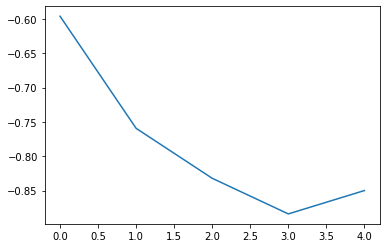

In [7]:
model = Resnet(0.01)
a = model.train(train_loader, 5)

plt.plot(a)

In [0]:
def prediction( self, data_loader):
    total_correct = 0
    total_examples  = 0
    with torch.no_grad():
      
      for inputs,label in data_loader:
        examples, channels,_,g = inputs.shape
        inputs, label = inputs.to( self.device), label.to( self.device)

        out = self.model(inputs)
        _,pred =  torch.max(out,1)
        correct = pred.eq( label).sum()
        total_correct += correct
        total_examples += examples
    return total_correct.item()/total_examples

model.predict = prediction.__get__( model, Resnet)

In [31]:
model.predict(train_loader)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.8562